# Purpose and Objectives:

Welcome! In this notebook, we will be covering the basics of autoencoder architectures, in particular the (vanilla) autoencoder and the variatonal autoencoder architectures. Throughout the notebook, there will be a set of concept check questions. You can find the corresponding question in our supplemental conceptual guide.

After completing this notebook, you will:


1.   Have a complete understanding of the general AE and VAE architectures
2.   Be able to implemting AEs and VAEs in Pytorch
3.   Evaluate the models' performance (loss/accuracy), denoising ability, and latent space through visualizations

*Note: It may be a good idea to review the basic principles of PCA as they will be referred to throughout the project*

## The Fundamental Setup of Autoencoder Architectures:

![AE.jpeg](img/AE.jpeg)

<p style="text-align: center;">Fig 1. A diagram of the general (Vanilla) Autoencoder architecture. </p>

As referenced in Hinton et. al., the purpose of autoencoders aligns very much with the motivations of PCA. One can consider the encoder to be a mapping from the high dimensional space of the input to the low-dimensional space of the latent representation. Similarly, the decoder *reconstructs* the low-dimensional represntation back into the original dimensionality. We discuss the purposes of this architecture in the next section.

### Concept Check 1.1.1

## Why Autoencoder Architectures? (Note to self: add images and figures later)

Autoencoder-style models have many different uses. We list several of the most notable ones here:

1.   **Dimensionality Reduction:** As mentioned in Hinton et. al., the *main* motivation for the AE architecutere is to turn "high-dimensional data" into "low dimensional codes". Adopting from the spirit of PCA, the encoder of an autoencoder can be thought of as a *nonlinear* map of the input data into the compressed space and the decoder an analogous yet opposite map that reconstructs the latent representation into the same dimensionality as the original input. Given sufficient data and computation, AEs can outperform PCA because *AEs are not limited to learning a linear representation of the data*. Datasets that feature high-dimensionality (e.g. biological/genetic data) can benefit from first applying AE dimensionality reduction before applying a later downstream task to the data. In this way, AE architectures can serve as a preprocessing step for other tasks. Note: a more general term for this in research is called **representation learning**.
2.   **Denoising:** Once again, similar to PCA, autoencoders can be utilized as preprocessing method for denoising data. Suppose we have an input vector $\vec{x}_i$ and we add some noise $\vec{\epsilon}$ to it. Then our minimization problem for the autoencoder becomes $\arg\min_{f, g} \sum_{i = 0}^{n}||\vec{x}_i - g(f(\vec{x}_i + \vec{\epsilon}))||^2$. From this objective, we see that an autoencoder used for denoising is motivated to ignore the noise.
3.   **Data Generation:** After properly training an autoencoder architecture, one can ignore the encoder half of the model and sample from the latent representation (or code) distribution. This sampled point can be passed through the decoder to hopefully generate new believable synthetic data.
4.   **Anomaly Detection:** Typically, the problem of anomaly detection involves classification of high dimensional data points (i.e. data with many features) into normal and anomalous samples (e.g. identifying anomolous credit card transaction). At a glance, the interpretations here can be similar to denoising, if we consider anomalies to be a type of "noise". There are many formulations and methematical tricks that can be used for anomaly detection. One common way is for the autoencoder to first learn a representation for the normal data. When running inference, the hope is that the reconstruction error can serve as a metric for evaluating whether a sample is anomolous or not. Intuitively, we would expect normal samples to be close in the low-dimensional space. On the contrary, anomalous samples would be expected to be far from the distribution of normal samples, yielding higher reconstruction error. Over the years many methods that leverage interpolation in the latent space, architectur improvements, and loss functions that incentivize clustering of normal and anomalous samples have been used. If you are curious to learn more about this field of research, refer to the following links: https://paperswithcode.com/task/anomaly-detection, https://github.com/yzhao062/anomaly-detection-resources

### Concept Check 1.1.2

We will now implement the autoencoder and variational autoencoder architectures to work on the MNIST dataset (chosen for its size and ease of visualization).

## AE With Linear Layers on MNIST:

If the following imports don't succeed, please refer to the README to ensure that you properly handled all dependencies. Note: It may take some time to run the imports the first time.

In [ ]:
import math
import random

import numpy as np
import pandas as pd

import sklearn
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.distributions import MultivariateNormal, Normal, Independent

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
# Reproducability
def reset_seeds():
    random.seed(0) # Python
    torch.manual_seed(0) # Torch
    np.random.seed(0) # NumPy

if not torch.cuda.is_available():
    print("Recommended to train on GPU if possible, will make training process faster")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We will start with implementing a simple Vanilla Autoencoder model. We will train it on the MNIST dataset. First, let us set up the MNIST dataloaders.

### Set up and visualize data

In [ ]:
# AE hyperparams
epochs = 5
lr = 1e-3
batch_size = 64
input_dim = 784
latent_dim = 512
noise = False

In [ ]:
# data
train_dataset = datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Labels: tensor([0, 4, 8, 7, 8, 9, 4, 6, 9, 6])


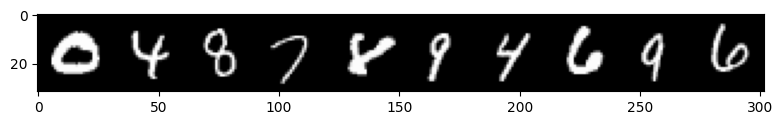

In [ ]:
# Visualize the data:

# Grab first batch of images:
images, labels = next(iter(train_dataloader))
    
# Print and show the first 10 samples:

print(f"Labels: {labels[0:10]}")
im = make_grid(images[:10], nrow=10)
plt.figure(figsize=(10,1))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC

Now that we have set up our data, let us construct the Vanilla Autoencoder with linear layers. We know that the input to the first layer should be the flattened MNIST data dimension. Following this, the layers of the AE encoder get iteratively smaller until the bottleneck (last layer of our encoder), which dictates the latent dimension size. The decoder is a mirror reflection of the encoder. Refer to [Hinton et. al.](https://www.science.org/doi/10.1126/science.1127647) for an idea on standard architecture if you are stuck. You may also utilize the helper code MLP, but it is not required.

### AE Model & Train

In [ ]:
#Some Optional Helper Code
def mlp(in_dim, out_dim, encode=True):
    # A helper function that compactly creates an MLP
    # where each layer is half of (or double) the size of the previous layer
    # depending on `encode`
    layers = []
    if encode:
        next_dim = 2**math.floor(math.log2(in_dim))
    else:
        next_dim = 2**math.ceil(math.log2(in_dim))
        
    firstLayer = nn.Linear(in_dim, next_dim)
    layers.extend([firstLayer, nn.ReLU()])
    in_dim = next_dim
        
    while in_dim != out_dim:
        if encode:
            next_dim = in_dim // 2
            if next_dim < out_dim:
                next_dim = out_dim
        else:
            next_dim = in_dim * 2
            if next_dim > out_dim:
                next_dim = out_dim
        layers.extend([nn.Linear(in_dim, next_dim), nn.ReLU()])
        in_dim = next_dim
        
    return nn.Sequential(*layers)

In [ ]:
class AE(nn.Module):
    def __init__(self, in_dim=784, latent_dim=512):
        super().__init__()
        

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z = self.encode(x_in)
        x_hat = self.decode(z)

        loss = self.loss(x_star, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat)
        return loss
    
    @staticmethod
    def loss(x, x_hat):
        loss = None

        # TODO: Mean-Squared Error Reconstruction Loss
        raise NotImplementedError()
        
        return loss



The training loop is set up for you. Feel free to tinker with the hyperparameters + model architecture at this point if you would like. On the default settings (with CUDA), this cell should take just over a minute to run.

In [ ]:
#Training Loop for Autoencoder

# model and optimizer
reset_seeds()
ae = AE(784, 512)
ae.to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
ae_train_losses = []
ae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        
        x_in = x_in.to(device)
        x_no_noise = x_no_noise.to(device)
        loss = ae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        ae_train_losses.append(loss.item()) # loss every iteration
        step += 1
        if step % report_every == 0:
            tqdm.write(f"Training loss: {loss}")
    # ae_train_losses.append(loss.detach().numpy()) # loss after every epoch
    # test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        X_test = X_test.to(device)
        loss = ae.test_step(X_test)
        ae_test_losses.append(loss.item()) # loss every iteration
    # ae_test_losses.append(loss.detach().numpy()) # loss after every epoch

Epoch 1


  6%|▌         | 58/938 [00:01<00:26, 33.84it/s]


KeyboardInterrupt: ignored

### Thinking Critically About the Architecture:

Alright, we have now trained our linear-layer (Vanilla) Autoencoder! Before directly moving on to Variational Autoencoders, let us see if we can't critically analyze the benefits and shortcomings of the Autoencoder.

Let us think a little more closely about the latent representation of the Autoencoder. We note that besides optimizing the reconstruction loss, there are no further restrictions on the latent code. Because of this, we can't really ensure that the latent space representation being learned is anything semantically meaningful or even practically useful (besides being good at reconstruction of course!).

Due to this lack of an informative latent space, (Vanilla) Autoencoders have more trouble with **denoising** and **content generation** tasks. One way to fix this is to regularize the latent code using some prior. 

![VAE_diagram.jpeg](img/VAE_diagram.jpeg)

<p style="text-align: center;">Fig 2. A diagram of the VAE architecture. </p>

Finally, to enforce this regularization, our loss objective thus becomes:

$$\|X - g(f(X))\|^2 + \lambda\mathrm{KL}[\mathcal{N}(\mu,\,\sigma^{2}), \mathcal{N}(0,\,I)]$$

where $\mathrm{KL}(\cdot)$ represents the KL-divergence. Without loss of generality, we measure the KL divergence between our latent distribution and the standard normal distribution.

### Concept Check 2.1

## VAE With Linear Layers on MNIST:

### VAE Model & Train

In [ ]:
# VAE hyperparams
epochs = 5
lr = 1e-3
batch_size = 64
noise = False
input_dim = 784
latent_dim=512
regularization_weight = .0001

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=1*28*28, latent_dim=512):
        super().__init__()
        self.z_mean = mlp(input_dim, latent_dim, encode=True)
        self.z_log_std = mlp(input_dim, latent_dim, encode=True)
        self.decoder = mlp(latent_dim, input_dim, encode=False)
    
    def _encode(self, x):
        # Output: latent_features is output of sampling q(z|x), log_prob 
        # Hint: Check out torch.distributions, in particular Independent and Normal
        # for calculating the log likelihood of your sampled z under q(z|x)
        latent_features = None
        log_prob = None

        raise NotImplementedError()
        return latent_features, log_prob 
        
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z, log_prob = self._encode(x_in)
        x_hat = self.decode(z)

        loss = self.loss(x_star, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat, z, log_prob)
        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=regularization_weight):
        # Output: loss given true data x, reconstructed data x_hat, 
        # sampled latent variables z, log likelihood of z under q(z|x), 
        # and the weight of the KL divergence term
        # Hint: check out torch.distributions, again specifically the MultivariateNormal
        # class to calculate the log likelihood of latent variables under a multivariate standard normal
        loss = None
        raise NotImplementedError()
        return loss

Again, feel free to tinker with the architecture or the hyperparameters if you would like. With the default settings, you should expect the following cell to take ~90 seconds to run

In [ ]:
# Training Loop for VAE

# model and optimizer
reset_seeds()
vae = VAE(input_dim, latent_dim)
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# train
vae_train_losses = []
vae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        x_in, x_no_noise = x_in.to(device), x_no_noise.to(device)
        loss = vae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        vae_train_losses.append(loss.item()) #loss every iteration
        step += 1
        if step % report_every == 0:
            tqdm.write(f"Training loss: {loss}")
    # vae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    # test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        X_test = X_test.to(device)
        loss = vae.test_step(X_test)
        vae_test_losses.append(loss.item()) #loss every iteration
    # vae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 11%|█         | 101/938 [00:02<00:23, 36.35it/s]

Training loss: 0.05027315393090248


 22%|██▏       | 207/938 [00:04<00:15, 48.56it/s]

Training loss: 0.03693041577935219


 33%|███▎      | 310/938 [00:06<00:10, 61.96it/s]

Training loss: 0.038339171558618546


 43%|████▎     | 408/938 [00:07<00:08, 65.37it/s]

Training loss: 0.03502336144447327


 54%|█████▍    | 506/938 [00:09<00:07, 59.92it/s]

Training loss: 0.033585578203201294


 65%|██████▌   | 613/938 [00:11<00:05, 64.59it/s]

Training loss: 0.03578009456396103


 76%|███████▌  | 712/938 [00:12<00:03, 62.13it/s]

Training loss: 0.03348476067185402


 86%|████████▋ | 810/938 [00:14<00:01, 64.62it/s]

Training loss: 0.03439272940158844


 97%|█████████▋| 906/938 [00:16<00:00, 48.04it/s]

Training loss: 0.030764687806367874


100%|██████████| 938/938 [00:16<00:00, 55.93it/s]


Epoch 2


  7%|▋         | 70/938 [00:01<00:13, 63.90it/s]

Training loss: 0.03225022554397583


 18%|█▊        | 168/938 [00:02<00:12, 60.08it/s]

Training loss: 0.03206564113497734


 29%|██▉       | 274/938 [00:04<00:10, 63.00it/s]

Training loss: 0.034338269382715225


 40%|███▉      | 372/938 [00:05<00:09, 60.70it/s]

Training loss: 0.03337612748146057


 50%|█████     | 470/938 [00:07<00:07, 62.47it/s]

Training loss: 0.03427469730377197


 61%|██████    | 570/938 [00:09<00:07, 50.86it/s]

Training loss: 0.028880296275019646


 72%|███████▏  | 671/938 [00:11<00:04, 61.14it/s]

Training loss: 0.03432872146368027


 82%|████████▏ | 769/938 [00:12<00:02, 64.01it/s]

Training loss: 0.03102196753025055


 93%|█████████▎| 874/938 [00:14<00:01, 62.70it/s]

Training loss: 0.02733169123530388


100%|██████████| 938/938 [00:15<00:00, 61.53it/s]


Epoch 3


  4%|▎         | 35/938 [00:00<00:13, 64.95it/s]

Training loss: 0.031791552901268005


 14%|█▍        | 133/938 [00:02<00:13, 60.72it/s]

Training loss: 0.0316869355738163


 24%|██▍       | 229/938 [00:03<00:13, 52.43it/s]

Training loss: 0.031248124316334724


 36%|███▌      | 334/938 [00:05<00:10, 55.45it/s]

Training loss: 0.03278594836592674


 47%|████▋     | 437/938 [00:07<00:07, 63.43it/s]

Training loss: 0.030592573806643486


 57%|█████▋    | 535/938 [00:08<00:06, 63.13it/s]

Training loss: 0.029490087181329727


 67%|██████▋   | 631/938 [00:10<00:04, 61.84it/s]

Training loss: 0.031194236129522324


 78%|███████▊  | 733/938 [00:12<00:03, 53.89it/s]

Training loss: 0.03139951080083847


 89%|████████▉ | 836/938 [00:13<00:01, 60.85it/s]

Training loss: 0.02798035740852356


 99%|█████████▉| 931/938 [00:15<00:00, 60.61it/s]

Training loss: 0.030534472316503525


100%|██████████| 938/938 [00:15<00:00, 59.78it/s]


Epoch 4


 10%|█         | 98/938 [00:01<00:13, 62.64it/s]

Training loss: 0.031053202226758003


 21%|██        | 196/938 [00:03<00:11, 63.33it/s]

Training loss: 0.02969737909734249


 31%|███▏      | 294/938 [00:04<00:10, 61.06it/s]

Training loss: 0.030424341559410095


 42%|████▏     | 392/938 [00:06<00:09, 58.77it/s]

Training loss: 0.03260689601302147


 53%|█████▎    | 496/938 [00:07<00:07, 62.28it/s]

Training loss: 0.02948516048491001


 63%|██████▎   | 594/938 [00:09<00:05, 62.35it/s]

Training loss: 0.028402939438819885


 74%|███████▍  | 694/938 [00:11<00:06, 36.57it/s]

Training loss: 0.028842691332101822


 85%|████████▍ | 793/938 [00:13<00:02, 54.20it/s]

Training loss: 0.027627035975456238


 95%|█████████▌| 893/938 [00:15<00:01, 40.42it/s]

Training loss: 0.028133809566497803


100%|██████████| 938/938 [00:16<00:00, 56.86it/s]


Epoch 5


  6%|▋         | 60/938 [00:01<00:14, 61.46it/s]

Training loss: 0.028945116326212883


 17%|█▋        | 155/938 [00:02<00:16, 46.65it/s]

Training loss: 0.027202878147363663


 27%|██▋       | 255/938 [00:04<00:11, 57.95it/s]

Training loss: 0.029096081852912903


 38%|███▊      | 359/938 [00:06<00:09, 61.29it/s]

Training loss: 0.029297921806573868


 49%|████▊     | 457/938 [00:08<00:07, 64.19it/s]

Training loss: 0.02946951985359192


 59%|█████▉    | 555/938 [00:09<00:06, 61.16it/s]

Training loss: 0.03137017786502838


 70%|███████   | 660/938 [00:11<00:04, 62.56it/s]

Training loss: 0.027749616652727127


 80%|████████  | 755/938 [00:13<00:03, 50.32it/s]

Training loss: 0.0324106402695179


 91%|█████████ | 854/938 [00:15<00:01, 49.63it/s]

Training loss: 0.027784429490566254


100%|██████████| 938/938 [00:16<00:00, 56.19it/s]


### Concept Check 2.2-2.3 (while you wait for the model to train)

## Ablations and Visualizations:

If you would like to understand more how these visualizations and ablations were implemented, feel free to peruse the code. However, for the most part take a close, critical look at the results. Some of these are really interesting and informative!

### 1. Loss Visualization:

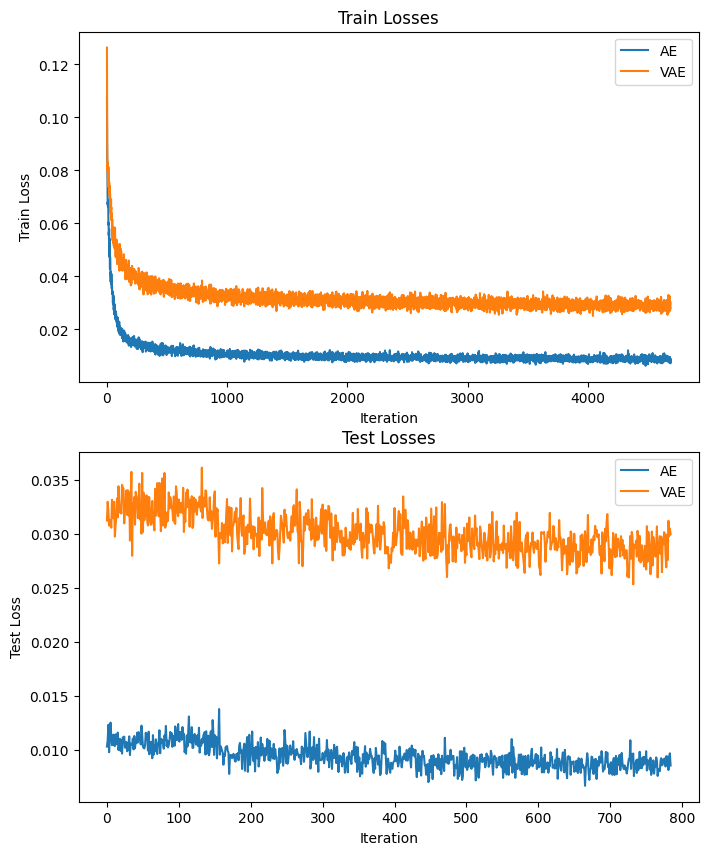

In [ ]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()
    
    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

### 2. Visualize Reconstructed Samples

Labels: tensor([5, 1, 7, 1, 6, 1, 7, 5, 0, 2])


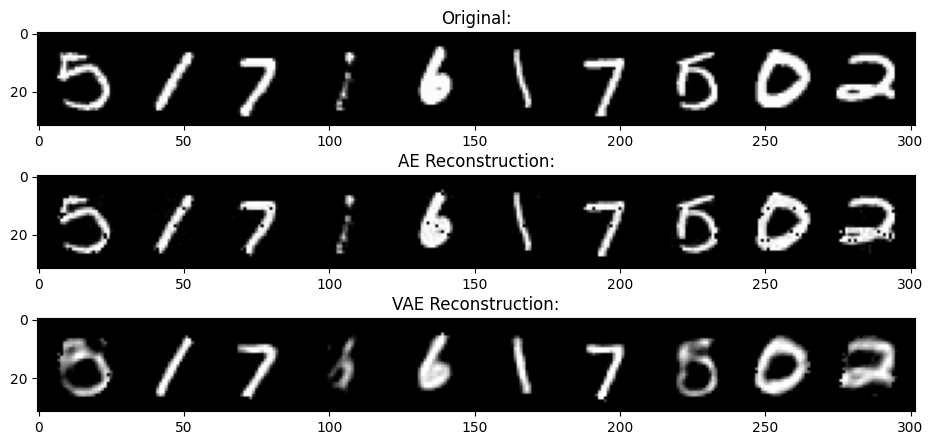

In [ ]:
# Visualize the samples in bulk:
with torch.no_grad():
    # Grab first batch of images:
    images, labels = next(iter(test_dataloader))
    flattened = images.reshape((batch_size, -1))
    flattened = flattened.to(device)
    recon_ae = ae.decode(ae.encode(flattened)).reshape((batch_size, 1, 28, 28))
    recon_vae = vae.decode(vae.encode(flattened)).reshape((batch_size, 1, 28, 28))
    
    # Print and show the first 10 samples:
    print(f"Labels: {labels[0:10]}")
    im = make_grid(images[:10], nrow=10)
    ae_im = make_grid(recon_ae[:10], nrow=10)
    vae_im = make_grid(recon_vae[:10], nrow=10)
    fig, ax = plt.subplots(3, figsize=(45,4.5))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.cpu().numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")

    ax[1].imshow(np.transpose(ae_im.cpu().numpy(), (1, 2, 0)))
    ax[1].set_title("AE Reconstruction:")
    
    ax[2].imshow(np.transpose(vae_im.cpu().numpy(), (1, 2, 0)))
    ax[2].set_title("VAE Reconstruction:")

### Concept Check 2.4.1

### 3. Visualizing the Latent Space:

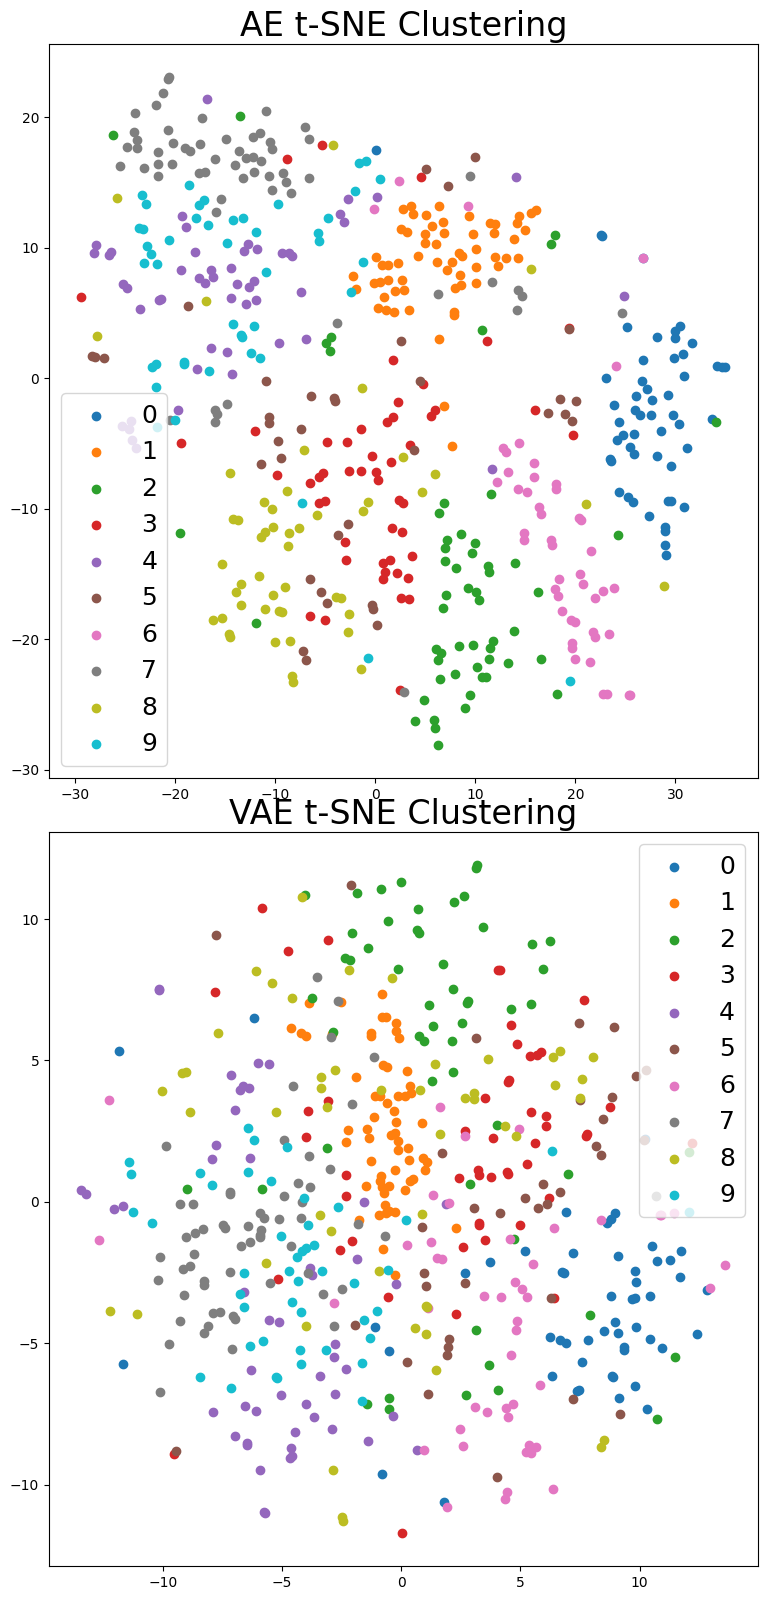

In [ ]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    data, labels = next(iter(viz_dataloader))
    tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
    flattened_data = data.reshape((num_samples, -1))
    flattened_data = flattened_data.to(device)
    recon_ae = ae.encode(flattened_data)
    recon_vae = vae.encode(flattened_data)
    embedded_ae = tsne.fit_transform(recon_ae.cpu())
    embedded_vae = tsne.fit_transform(recon_vae.cpu())
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig, ax = plt.subplots(2, figsize=(8,16))
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax[0].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[0].legend(labels=range(10), fontsize=18)
    ax[0].set_title("AE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[0].show()
    
    for label, group in label_groups_vae:
        ax[1].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[1].legend(labels=range(10), fontsize=18)
    ax[1].set_title("VAE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[1].show()

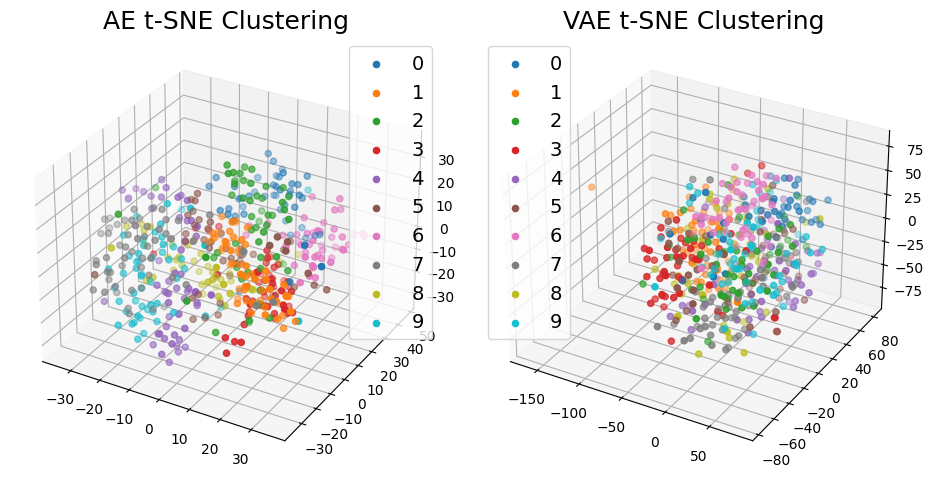

In [ ]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    data, labels = next(iter(viz_dataloader))

    tsne = TSNE(n_components=3, perplexity=30.0, random_state=0)
    flattened_data = data.reshape((num_samples, -1))
    flattened_data = flattened_data.to(device)
    recon_ae = ae.encode(flattened_data)
    recon_vae = vae.encode(flattened_data)
    embedded_ae = tsne.fit_transform(recon_ae.cpu())
    embedded_vae = tsne.fit_transform(recon_vae.cpu())
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "c3", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2","c3", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax0.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax0.legend(labels=range(10), fontsize=14)
    ax0.set_title("AE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[0].show()
    
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    for label, group in label_groups_vae:
        ax1.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax1.legend(labels=range(10), fontsize=14)
    ax1.set_title("VAE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[1].show()

### Concept Check 2.4.2

### 4. AE/VAE Denoising:

Now, let us see the denoising capabilities of these architectures. Go back to the function add noise in order to add some Gaussian noise to the training data, $X$. You can adjust how reasonable the noise is by adding a coefficient in front of the noise term, which can act as a hyperparameter. Then, apply this noise to the sample when training.

*(Hint: torch.randn may be helpful here. Also, consider what range of values may be outputted when you add noise. Is this consistent with the data type of MNIST? How might you account for this.)*

In [ ]:
def add_noise(tensor, mean=0., std=1., noise_weight=0.5):
    # TODO
    raise NotImplementedError()

In [ ]:
noise = True
epochs = 20


In [ ]:
#@title The training loops for AE and VAE are replicated below for your convenience
#Training Loop for Autoencoder

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

#Training Loop for Autoencoder

# model and optimizer
reset_seeds()
ae = AE(784, 512)
ae.to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
ae_train_losses = []
ae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        
        x_in = x_in.to(device)
        x_no_noise = x_no_noise.to(device)
        loss = ae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        ae_train_losses.append(loss.item()) # loss every iteration
        step += 1
        if step % report_every == 0:
            tqdm.write(f"Training loss: {loss}")
    # ae_train_losses.append(loss.detach().numpy()) # loss after every epoch
    # test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        X_test = X_test.to(device)
        loss = ae.test_step(X_test)
        ae_test_losses.append(loss.item()) # loss every iteration
    # ae_test_losses.append(loss.detach().numpy()) # loss after every epoch

# Training Loop for VAE

# model and optimizer
reset_seeds()
vae = VAE(input_dim, latent_dim)
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# train
vae_train_losses = []
vae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        x_in, x_no_noise = x_in.to(device), x_no_noise.to(device)
        loss = vae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        vae_train_losses.append(loss.item()) #loss every iteration
        step += 1
        if step % report_every == 0:
            tqdm.write(f"Training loss: {loss}")
    # vae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    # test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        X_test = X_test.to(device)
        loss = vae.test_step(X_test)
        vae_test_losses.append(loss.item()) #loss every iteration
    # vae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 55%|█████▌    | 516/938 [00:05<00:04, 89.33it/s]

Training loss: 0.025528473779559135


100%|██████████| 938/938 [00:11<00:00, 85.14it/s]


Epoch 2


  8%|▊         | 76/938 [00:00<00:10, 86.03it/s]

Training loss: 0.023410243913531303


 61%|██████    | 571/938 [00:06<00:05, 69.39it/s]

Training loss: 0.021495075896382332


100%|██████████| 938/938 [00:11<00:00, 82.20it/s]


Epoch 3


 14%|█▍        | 136/938 [00:01<00:08, 89.66it/s]

Training loss: 0.022814666852355003


 68%|██████▊   | 637/938 [00:07<00:04, 67.02it/s]

Training loss: 0.019083203747868538


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]


Epoch 4


 21%|██▏       | 200/938 [00:02<00:08, 86.07it/s]

Training loss: 0.020574698224663734


 74%|███████▍  | 697/938 [00:08<00:03, 76.00it/s]

Training loss: 0.018641700968146324


100%|██████████| 938/938 [00:11<00:00, 83.16it/s]


Epoch 5


 27%|██▋       | 257/938 [00:02<00:08, 84.89it/s]

Training loss: 0.02047223597764969


 81%|████████  | 758/938 [00:09<00:02, 82.72it/s]

Training loss: 0.018532775342464447


100%|██████████| 938/938 [00:11<00:00, 80.16it/s]


Epoch 6


 34%|███▍      | 323/938 [00:03<00:06, 90.02it/s]

Training loss: 0.018817465752363205


 88%|████████▊ | 823/938 [00:09<00:01, 82.56it/s]

Training loss: 0.019319217652082443


100%|██████████| 938/938 [00:11<00:00, 84.71it/s]


Epoch 7


 41%|████      | 380/938 [00:04<00:06, 79.80it/s]

Training loss: 0.01872984878718853


 94%|█████████▍| 880/938 [00:15<00:00, 78.29it/s]

Training loss: 0.01903541386127472


100%|██████████| 938/938 [00:16<00:00, 57.01it/s]


Epoch 8


 48%|████▊     | 446/938 [00:05<00:05, 87.33it/s]

Training loss: 0.01964094117283821


100%|██████████| 938/938 [00:10<00:00, 87.50it/s]


Training loss: 0.017064033076167107
Epoch 9


 53%|█████▎    | 495/938 [00:05<00:04, 89.66it/s]

Training loss: 0.01698402687907219


100%|██████████| 938/938 [00:10<00:00, 86.27it/s]


Epoch 10


  7%|▋         | 67/938 [00:00<00:10, 80.21it/s]

Training loss: 0.017268028110265732


 60%|██████    | 567/938 [00:06<00:04, 89.28it/s]

Training loss: 0.01617220789194107


100%|██████████| 938/938 [00:10<00:00, 87.44it/s]


Epoch 11


 14%|█▍        | 129/938 [00:01<00:09, 86.39it/s]

Training loss: 0.01982612907886505


 67%|██████▋   | 630/938 [00:07<00:03, 88.16it/s]

Training loss: 0.016078194603323936


100%|██████████| 938/938 [00:10<00:00, 85.62it/s]


Epoch 12


 20%|██        | 191/938 [00:02<00:08, 89.39it/s]

Training loss: 0.015524703077971935


 74%|███████▎  | 691/938 [00:07<00:02, 89.43it/s]

Training loss: 0.017343346029520035


100%|██████████| 938/938 [00:10<00:00, 86.68it/s]


Epoch 13


 27%|██▋       | 253/938 [00:03<00:07, 90.38it/s]

Training loss: 0.016649648547172546


 80%|████████  | 752/938 [00:08<00:02, 66.07it/s]

Training loss: 0.017057636752724648


100%|██████████| 938/938 [00:12<00:00, 76.27it/s]


Epoch 14


 34%|███▍      | 320/938 [00:03<00:07, 87.33it/s]

Training loss: 0.015452021732926369


 87%|████████▋ | 816/938 [00:09<00:01, 80.97it/s]

Training loss: 0.019065849483013153


100%|██████████| 938/938 [00:11<00:00, 84.89it/s]


Epoch 15


 41%|████      | 383/938 [00:04<00:06, 85.68it/s]

Training loss: 0.017327263951301575


 94%|█████████▍| 885/938 [00:10<00:00, 88.21it/s]

Training loss: 0.01779886893928051


100%|██████████| 938/938 [00:11<00:00, 84.15it/s]


Epoch 16


 47%|████▋     | 443/938 [00:05<00:05, 82.93it/s]

Training loss: 0.015676625072956085


100%|██████████| 938/938 [00:11<00:00, 83.71it/s]


Training loss: 0.017311910167336464
Epoch 17


 54%|█████▎    | 502/938 [00:05<00:04, 91.71it/s]

Training loss: 0.017099324613809586


100%|██████████| 938/938 [00:11<00:00, 85.04it/s]


Epoch 18


  7%|▋         | 65/938 [00:00<00:09, 87.96it/s]

Training loss: 0.016306567937135696


 60%|█████▉    | 561/938 [00:06<00:05, 74.08it/s]

Training loss: 0.01647481881082058


100%|██████████| 938/938 [00:11<00:00, 83.03it/s]


Epoch 19


 14%|█▍        | 129/938 [00:01<00:09, 86.98it/s]

Training loss: 0.01622346229851246


 67%|██████▋   | 627/938 [00:08<00:05, 58.98it/s]

Training loss: 0.015156825073063374


100%|██████████| 938/938 [00:11<00:00, 80.88it/s]


Epoch 20


 21%|██        | 194/938 [00:02<00:08, 85.38it/s]

Training loss: 0.01614975929260254


 73%|███████▎  | 688/938 [00:08<00:02, 87.56it/s]

Training loss: 0.017237873747944832


100%|██████████| 938/938 [00:11<00:00, 83.89it/s]


Epoch 1


 54%|█████▍    | 510/938 [00:09<00:07, 60.08it/s]

Training loss: 0.042853426188230515


100%|██████████| 938/938 [00:16<00:00, 57.34it/s]


Epoch 2


  7%|▋         | 69/938 [00:01<00:15, 55.60it/s]

Training loss: 0.036998502910137177


 61%|██████    | 573/938 [00:09<00:06, 57.30it/s]

Training loss: 0.038283493369817734


100%|██████████| 938/938 [00:16<00:00, 55.96it/s]


Epoch 3


 14%|█▍        | 129/938 [00:02<00:13, 57.81it/s]

Training loss: 0.036456383764743805


 67%|██████▋   | 632/938 [00:11<00:05, 56.75it/s]

Training loss: 0.03666640445590019


100%|██████████| 938/938 [00:16<00:00, 56.94it/s]


Epoch 4


 21%|██        | 193/938 [00:03<00:13, 54.86it/s]

Training loss: 0.03410683944821358


 74%|███████▍  | 697/938 [00:12<00:04, 55.83it/s]

Training loss: 0.036653369665145874


100%|██████████| 938/938 [00:16<00:00, 57.00it/s]


Epoch 5


 27%|██▋       | 256/938 [00:04<00:15, 45.01it/s]

Training loss: 0.036787208169698715


 80%|████████  | 754/938 [00:13<00:03, 58.48it/s]

Training loss: 0.03539567068219185


100%|██████████| 938/938 [00:16<00:00, 55.84it/s]


Epoch 6


 34%|███▎      | 316/938 [00:05<00:10, 59.43it/s]

Training loss: 0.0322631299495697


 87%|████████▋ | 819/938 [00:14<00:02, 46.43it/s]

Training loss: 0.035118453204631805


100%|██████████| 938/938 [00:16<00:00, 56.59it/s]


Epoch 7


 41%|████      | 380/938 [00:07<00:09, 56.93it/s]

Training loss: 0.03175719082355499


 94%|█████████▍| 880/938 [00:15<00:01, 45.89it/s]

Training loss: 0.03251805528998375


100%|██████████| 938/938 [00:16<00:00, 55.38it/s]


Epoch 8


 48%|████▊     | 446/938 [00:07<00:08, 59.45it/s]

Training loss: 0.03308746963739395


100%|██████████| 938/938 [00:16<00:00, 57.79it/s]


Training loss: 0.034430138766765594
Epoch 9


 54%|█████▍    | 506/938 [00:09<00:07, 57.71it/s]

Training loss: 0.03463435545563698


100%|██████████| 938/938 [00:16<00:00, 55.61it/s]


Epoch 10


  7%|▋         | 69/938 [00:01<00:14, 58.31it/s]

Training loss: 0.02971317060291767


 60%|██████    | 567/938 [00:10<00:07, 50.26it/s]

Training loss: 0.03375678509473801


100%|██████████| 938/938 [00:16<00:00, 57.54it/s]


Epoch 11


 14%|█▎        | 127/938 [00:02<00:16, 48.66it/s]

Training loss: 0.03612546622753143


 67%|██████▋   | 629/938 [00:11<00:05, 56.30it/s]

Training loss: 0.033999886363744736


100%|██████████| 938/938 [00:16<00:00, 55.66it/s]


Epoch 12


 21%|██        | 193/938 [00:03<00:13, 57.22it/s]

Training loss: 0.033384863287210464


 73%|███████▎  | 688/938 [00:12<00:04, 57.27it/s]

Training loss: 0.03347953408956528


100%|██████████| 938/938 [00:16<00:00, 56.31it/s]


Epoch 13


 27%|██▋       | 255/938 [00:04<00:11, 59.25it/s]

Training loss: 0.0318944975733757


 80%|████████  | 754/938 [00:13<00:03, 56.60it/s]

Training loss: 0.03436921909451485


100%|██████████| 938/938 [00:16<00:00, 56.06it/s]


Epoch 14


 33%|███▎      | 314/938 [00:05<00:11, 56.70it/s]

Training loss: 0.03311069309711456


 87%|████████▋ | 812/938 [00:14<00:02, 54.75it/s]

Training loss: 0.03446771204471588


100%|██████████| 938/938 [00:16<00:00, 57.12it/s]


Epoch 15


 40%|███▉      | 374/938 [00:06<00:10, 56.23it/s]

Training loss: 0.03322944790124893


 93%|█████████▎| 874/938 [00:15<00:01, 55.11it/s]

Training loss: 0.030574647709727287


100%|██████████| 938/938 [00:17<00:00, 54.94it/s]


Epoch 16


 46%|████▋     | 435/938 [00:07<00:11, 43.13it/s]

Training loss: 0.033533405512571335


100%|██████████| 938/938 [00:16<00:00, 57.29it/s]


Training loss: 0.034790556877851486
Epoch 17


 53%|█████▎    | 497/938 [00:08<00:08, 51.55it/s]

Training loss: 0.03284517675638199


100%|██████████| 938/938 [00:16<00:00, 56.01it/s]


Epoch 18


  6%|▋         | 60/938 [00:01<00:15, 57.80it/s]

Training loss: 0.03383117541670799


 60%|██████    | 563/938 [00:10<00:06, 59.74it/s]

Training loss: 0.03220795840024948


100%|██████████| 938/938 [00:16<00:00, 56.74it/s]


Epoch 19


 13%|█▎        | 126/938 [00:02<00:14, 57.82it/s]

Training loss: 0.0308412816375494


 67%|██████▋   | 625/938 [00:10<00:05, 60.89it/s]

Training loss: 0.031543999910354614


100%|██████████| 938/938 [00:16<00:00, 56.91it/s]


Epoch 20


 20%|█▉        | 187/938 [00:03<00:12, 58.31it/s]

Training loss: 0.033813122659921646


 73%|███████▎  | 689/938 [00:12<00:04, 59.18it/s]

Training loss: 0.033019986003637314


100%|██████████| 938/938 [00:16<00:00, 56.39it/s]


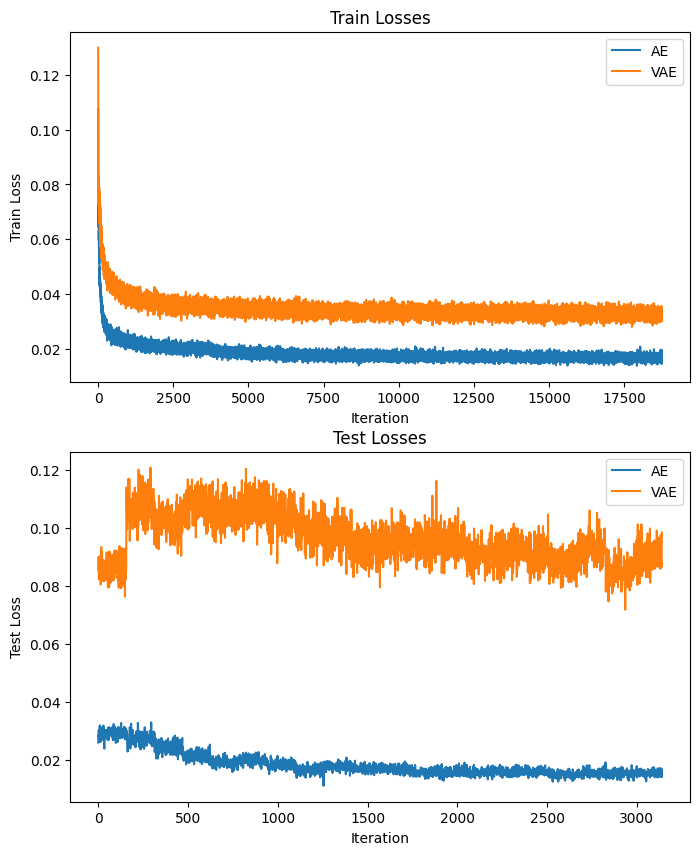

In [ ]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()

    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

Labels: tensor([1, 0, 6, 5, 8, 8, 5, 9, 8, 0])


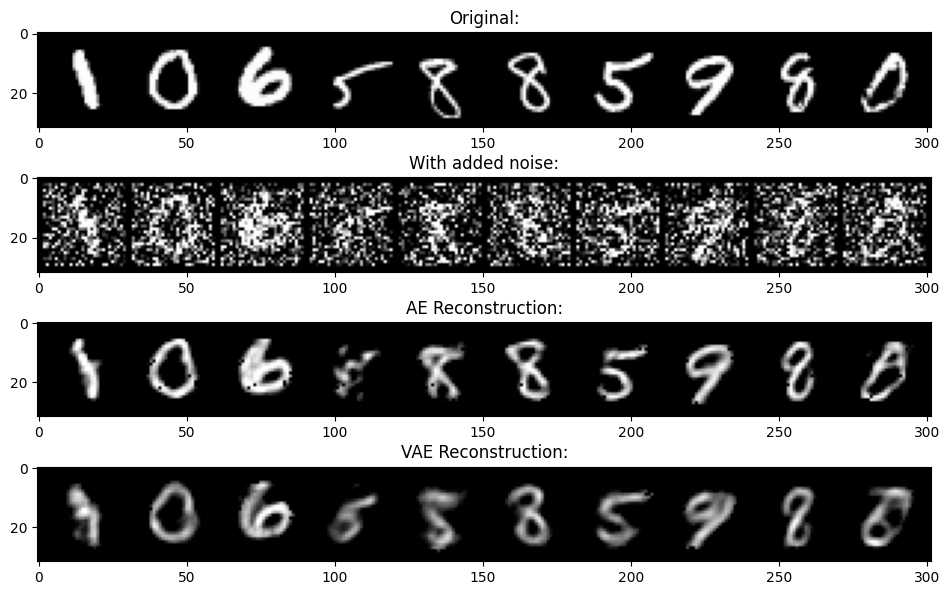

In [ ]:
# Visualize the samples in bulk:

with torch.no_grad():
    # Grab first batch of images:
    images, labels = next(iter(test_dataloader))


    # Add Noise to images:
    noise_images = add_noise(images, noise_weight=0.65)
    flattened_noise_images = noise_images.reshape((batch_size, -1))
    flattened_noise_images = flattened_noise_images.to(device)
    recon_ae = ae.decode(ae.encode(flattened_noise_images)).reshape((batch_size, 1, 28, 28))
    recon_vae = vae.decode(vae.encode(flattened_noise_images)).reshape((batch_size, 1, 28, 28))
    
    # Print and show the first 10 samples:
    print(f"Labels: {labels[0:10]}")
    im = make_grid(images[:10], nrow=10)
    noise_im = make_grid(noise_images[:10], nrow=10)
    ae_im = make_grid(recon_ae[:10], nrow=10)
    vae_im = make_grid(recon_vae[:10], nrow=10)
    fig, ax = plt.subplots(4, figsize=(60,6))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.cpu().numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")
    
    ax[1].imshow(np.transpose(noise_im.cpu().numpy(), (1, 2, 0)))
    ax[1].set_title("With added noise:")

    ax[2].imshow(np.transpose(ae_im.cpu().numpy(), (1, 2, 0)))
    ax[2].set_title("AE Reconstruction:")
    
    ax[3].imshow(np.transpose(vae_im.cpu().numpy(), (1, 2, 0)))
    ax[3].set_title("VAE Reconstruction:")

### Concept Check 2.3.3

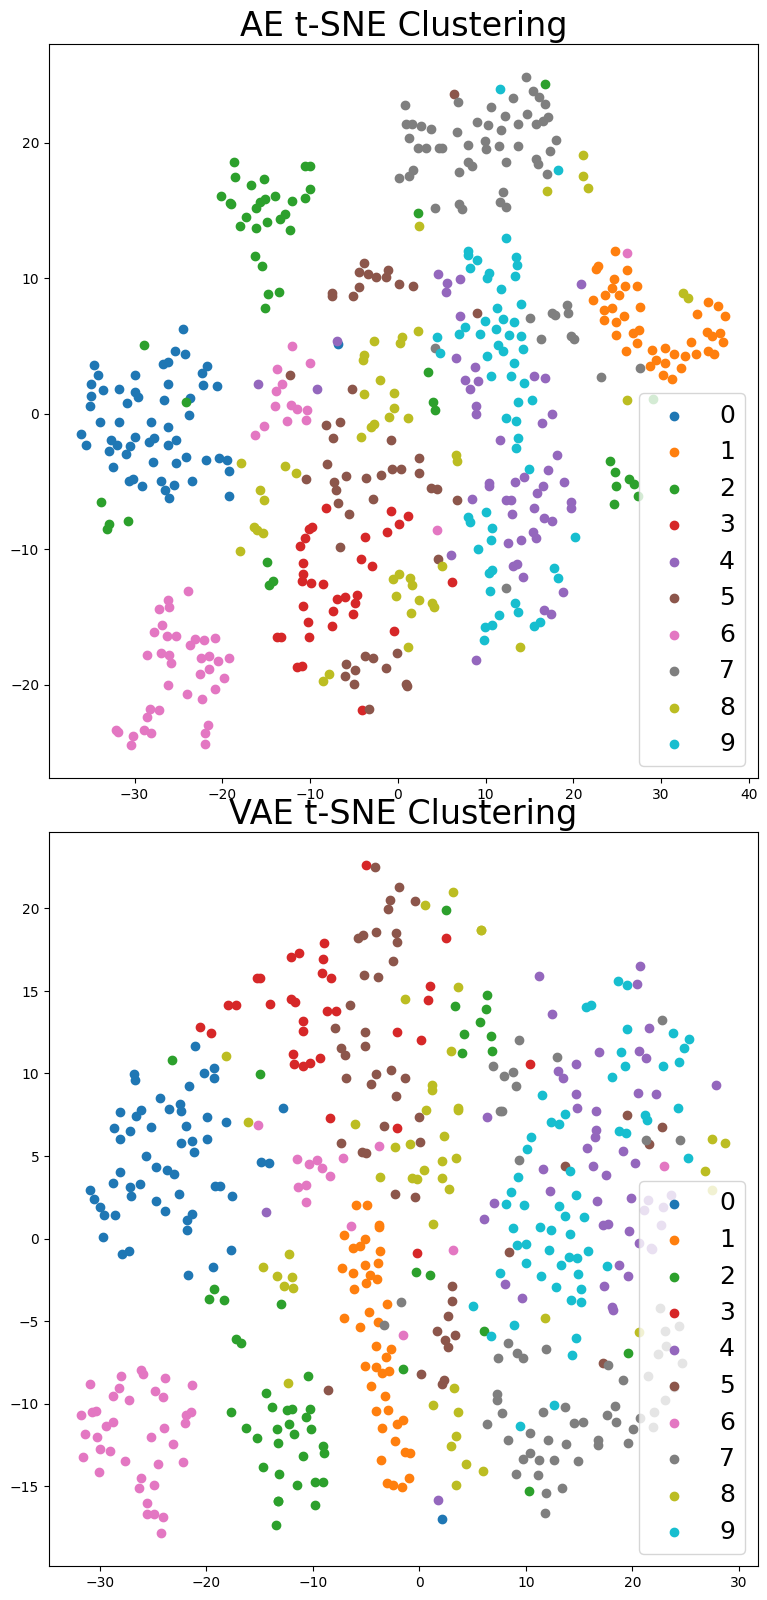

In [ ]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    data, labels = next(iter(viz_dataloader))
    flattened_data = data.reshape((num_samples, -1))
    flattened_data = flattened_data.to(device)

    tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(flattened_data)
    recon_vae = vae.encode(flattened_data)
    embedded_ae = tsne.fit_transform(recon_ae.cpu())
    embedded_vae = tsne.fit_transform(recon_vae.cpu())
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig, ax = plt.subplots(2, figsize=(8,16))
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax[0].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[0].legend(labels=range(10), fontsize=18)
    ax[0].set_title("AE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[0].show()
    
    for label, group in label_groups_vae:
        ax[1].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[1].legend(labels=range(10), fontsize=18)
    ax[1].set_title("VAE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[1].show()

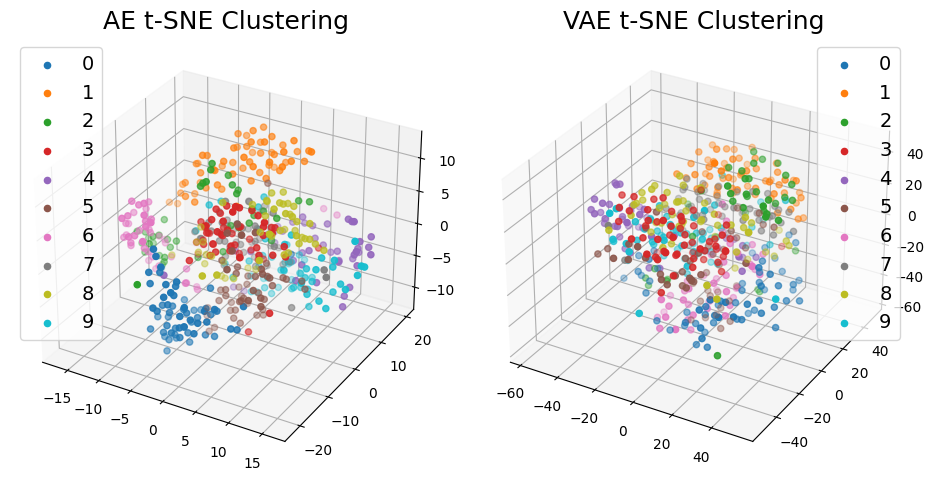

In [ ]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    data, labels = next(iter(viz_dataloader))

    flattened_data = data.reshape((num_samples, -1)).to(device)
    tsne = TSNE(n_components=3, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(flattened_data)
    recon_vae = vae.encode(flattened_data)
    embedded_ae = tsne.fit_transform(recon_ae.cpu())
    embedded_vae = tsne.fit_transform(recon_vae.cpu())
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "c3", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2","c3", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax0.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax0.legend(labels=range(10), fontsize=14)
    ax0.set_title("AE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[0].show()
    
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    for label, group in label_groups_vae:
        ax1.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax1.legend(labels=range(10), fontsize=14)
    ax1.set_title("VAE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[1].show()

### 5. Generating New Samples

#### 5a. AE:

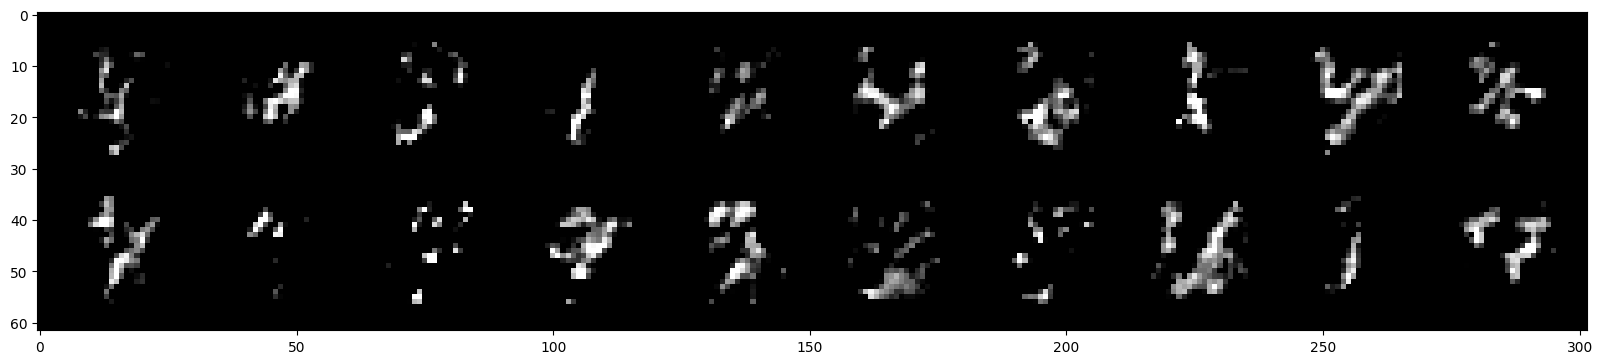

In [ ]:
ae.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_dataloader))
  
    flattened_images = images.reshape((batch_size, -1)).to(device)
    latent = vae.encode(flattened_images)
    latent = latent.cpu()
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(batch_size, latent_dim)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = ae.decode(latent)
    img_recon = img_recon.reshape((batch_size, 1, 28, 28)).cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    im = make_grid(img_recon[:20], nrow=10)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    plt.show()

#### 5b. VAE:

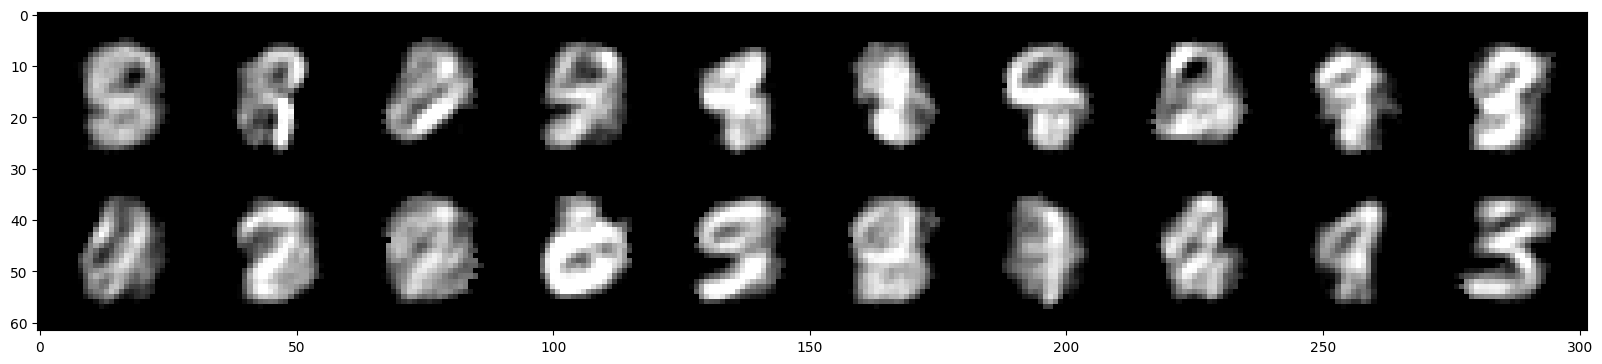

In [ ]:
vae.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_dataloader))
    images = images.to(device)
    latent = vae.encode(images.reshape((batch_size, -1)))
    latent = latent.cpu()
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(batch_size, latent_dim)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = vae.decode(latent)
    img_recon = img_recon.reshape((batch_size, 1, 28, 28)).cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    im = make_grid(img_recon[:20], nrow=10)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    plt.show()

### Concept Check 2.3.4

## References:

Any references utilized in this project can be found in the README of our repo.

In [ ]:
#@title A faster version (no training losses, only denoising, AE)
#Training Loop for Autoencoder

# model and optimizer
reset_seeds()
ae = AE(784, 512)
ae.to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr, capturable=True)

warmup_iterator = iter(train_dataloader)
x, y = next(warmup_iterator)
x_no_noise = x.reshape(x.shape[0], -1)
x_in = add_noise(x_no_noise, noise_weight=0.5)
static_input = torch.zeros_like(x_in, device=device).copy_(x_in)
static_target = torch.zeros_like(x_no_noise, device=device).copy_(x_no_noise)

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(3):
        x, _ = next(warmup_iterator)
        x_no_noise = x.reshape(x.shape[0], -1)
        x_in = add_noise(x_no_noise, noise_weight=0.5)
        x_in = x_in.to(device)
        x_no_noise = x_no_noise.to(device)
        loss = ae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
torch.cuda.current_stream().wait_stream(s)

# capture
g = torch.cuda.CUDAGraph()
# Sets grads to None before capture, so backward() will create
# .grad attributes with allocations from the graph's private pool
optimizer.zero_grad(set_to_none=True)
with torch.cuda.graph(g):
    static_input = add_noise(static_target, noise_weight=0.5)
    loss = ae.train_step(optimizer, x_in=static_input, x_star=static_target)

# train
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if x.shape != static_input.shape:
          continue
        static_target.copy_(x_no_noise)

        g.replay()
        
        step += 1
        if step % report_every == 0:
            tqdm.write(f"Training loss: {loss}")
    # ae_train_losses.append(loss.detach().numpy()) # loss after every epoch
    # test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        X_test = X_test.to(device)
        loss = ae.test_step(X_test)
        ae_test_losses.append(loss.item()) # loss every iteration
    # ae_test_losses.append(loss.detach().numpy()) # loss after every epoch

Epoch 1


100%|██████████| 938/938 [00:08<00:00, 110.11it/s]


Epoch 2


100%|██████████| 938/938 [00:08<00:00, 116.48it/s]


Epoch 3


100%|██████████| 938/938 [00:08<00:00, 104.26it/s]


Epoch 4


100%|██████████| 938/938 [00:08<00:00, 110.84it/s]


Epoch 5


100%|██████████| 938/938 [00:11<00:00, 81.82it/s]
